In [18]:
import os
import numpy as np
from numpy.lib.stride_tricks import as_strided
import time
import matplotlib.pyplot as plt
from scipy.spatial.distance import directed_hausdorff
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR

from pytorch_lightning import LightningDataModule
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split

from monai.networks.nets import SwinUNETR
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric, MeanIoU, HausdorffDistanceMetric
from monai.transforms import (
    AsDiscreted,
    Compose,
    Resized,
    EnsureChannelFirstd,
    LoadImaged,
    ScaleIntensityd,
    ToTensord,
    RandFlipd,
    RandZoomd, 
    ToTensord, 
    AsDiscreted,
    CenterSpatialCropd
)

In [19]:
# Custom dataset class for pytorch compatibility
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class EndoVis2017Dataset(Dataset):
    def __init__(self, label_subdir=None):
        self.data = []

        if label_subdir is None:
            raise ValueError("You must specify a `label_subdir` for ground truth masks (e.g., 'instrument_seg_composite').")

        self.root_dir = "C:/Users/dsumm/OneDrive/Documents/UMD ENPM Robotics Files/BIOE658B (Intro to Medical Image Analysis)/Project/dataset/train/"
        self.label_subdir = label_subdir

        # Recursively walk through directory to find left frame image paths and GT image paths
        for subdir, dirs, files in os.walk(self.root_dir):
            if 'left_frames' in subdir:
                #print("Hit!")
                for file in sorted(files):
                    if file.endswith(('.png', '.jpg', '.jpeg')):                     
                        img_path = os.path.join(subdir, file)
                        #print(img_path)

                        gt_root = subdir.replace('left_frames', 'ground_truth')
                        mask_path = os.path.join(gt_root, self.label_subdir, file)

                        if os.path.exists(mask_path):
                            #print("Hit!")
                            self.data.append({"image": img_path, "label": mask_path})    # Dictionary for MONAI compatability

        transforms_list = [
            LoadImaged(keys=["image", "label"]),                        # Loads image data and metadata from file path dictionaries
            EnsureChannelFirstd(keys=["image", "label"]),               # Adjust or add the channel dimension of input data to ensure channel_first shape

            # Images are of nominal size 1280x1024 --> resizing for memory efficiency
            CenterSpatialCropd(keys=["image", "label"], roi_size=(1024, 1280)),         # Cropping background padding from images
            Resized(keys=["image", "label"], spatial_size=(256, 320)),                  # Imported images are of various sizes: standardize to 320,256

            # Apply data augmentation techniqes
            RandFlipd(keys=["image", "label"], prob=0.3, spatial_axis=1),               # Horizontal axis flip imposed w/ 30% prob
            #RandRotate90d(keys=["image", "label"], prob=0.3, max_k=3),                  # Random 90° rotation imposed w/ 30% prob
            RandZoomd(keys=["image", "label"], prob=0.3, min_zoom=0.75, max_zoom=1.25), # Zoom range (+/-25%) imposed w/ 30% prob
            #RandAdjustContrastd(keys=["image"], prob=0.3, gamma=(0.75, 1.25)),          # Contrast variation (+/-25%) imposed w/ 30% prob

            ScaleIntensityd(keys=["image"]),                            # Scale the intensity of input image to the value range 0-1
            ToTensord(keys=["image", "label"]),                         # Ensure data is of tensor type for pytorch usage
        ]

        # Additional conditional transforms based on label_subdir
        if label_subdir == "binary_composite":
            transforms_list.append(AsDiscreted(keys=["label"], threshold=0.5))         # Binary threshold for binary seg
        elif label_subdir == "part_seg_composite":
            transforms_list.append(AsDiscreted(keys=["label"], to_onehot=5))           # 5 individual class labels for instrument independent part seg
        elif label_subdir == "instrument_seg_composite":
            transforms_list.append(AsDiscreted(keys=["label"], to_onehot=8))            # 8 individual class labels for part independent instrument seg
        elif label_subdir == "instrument_part_seg_composite":
            transforms_list.append(AsDiscreted(keys=["label"], to_onehot=21))           # 26 individual class labels for instrument & part seg

        # Imposing MONAI transforms
        # https://docs.monai.io/en/stable/transforms.html
        self.transform = Compose(transforms_list)

    def __len__(self):
        # Returns number of imported samples
        length = len(self.data)
        return length

    def __getitem__(self, idx):
        # Return transformed sample from the dataset as dictated by the index
        sample = self.data[idx]
        return self.transform(sample)

In [20]:
class MONAIDataLoader(LightningDataModule):
    def __init__(self, dataset=None, batch_size: int = None, img_size: int = None, dimensions:int = None):
        super().__init__()
        if dataset is None:
            raise ValueError("No dataset given!")
        else:
            self.dataset = dataset

        self.train, self.val = random_split(self.dataset, [int(len(self.dataset) * 0.8), len(self.dataset) - int(len(self.dataset) * 0.8)])
        self.batch_size = batch_size
        #self.num_workers = 2
        self.pin_memory = True
        #self.persistent_workers = True
        print(f"Train dataset size: {len(self.train)}")
        print(f"Validation dataset size: {len(self.val)}")

    def setup(self, stage=None):
        # required by PyTorch Lightning
        pass

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, pin_memory=self.pin_memory)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, pin_memory=self.pin_memory)

    #def predict_dataloader(self):
    #    return DataLoader(self.test, batch_size=self.batch_size, num_workers=16)

In [21]:
class SwinUNETR_Train(LightningModule):
    def __init__(self, img_size=(1, 3, 256, 320), batch_size=1, lr=0.001, num_classes=1):
        super().__init__()

        self.save_hyperparameters()
        self.num_classes = num_classes
        print("num_classes", self.num_classes, num_classes, self.hparams.num_classes)
        self.example_input_array = [torch.zeros(self.hparams.img_size)]

        self.dice_metric = DiceMetric(include_background=True, reduction="mean", ignore_empty=True)
        self.iou_metric = MeanIoU(include_background=True, reduction="mean", ignore_empty=True)

        # Metric tracking
        self.dice_scores = []
        self.iou_scores = []

        # Define SwinUNETR model from MONAI
        self.model = SwinUNETR(
            img_size=(256,320),
            in_channels=3,
            out_channels=self.num_classes,
            feature_size=48,                        # common starting point; can increase to 96/128
            drop_rate=0.1,                          # 10% dropout probability
            use_checkpoint=True,                     # Enable gradient checkpointing to save memory
            spatial_dims = 2,
        )

        # Using combined DICE and CE loss as loss function
        # Conditional loss function based on the number of classes
        if num_classes == 1:
            self.DICE_CE_Loss = DiceCELoss(
                include_background=False,  # Exclude background class
                sigmoid=True,  # Use softmax for multiclass segmentation
                softmax=False,  # Apply softmax for multiclass
                lambda_dice=1.0,  # Adjust the weight for Dice loss
                lambda_ce=1.0,  # Adjust the weight for Cross-Entropy loss
                reduction='mean'  # Use mean reduction
            )
        else:
            self.DICE_CE_Loss = DiceCELoss(
                include_background=False,  # Exclude background class
                sigmoid=False,  # Use softmax for multiclass segmentation
                softmax=True,  # Apply softmax for multiclass
                lambda_dice=1.0,  # Adjust the weight for Dice loss
                lambda_ce=1.0,  # Adjust the weight for Cross-Entropy loss
                reduction='mean'  # Use mean reduction
            )

        # Tracking losses for matplotlib
        self.train_losses = []
        self.val_losses = []

        # For storing images for the last epoch
        self.last_image = []
        self.last_pred = []
        self.last_mask = []
        self.logged_epochs = []

    # Passes model inputs through U-net to get output predictions
    def forward(self, inputs):
        outputs = self.model(inputs)
        return outputs

    def training_step(self, batch, batch_idx):
        # Gets labels for input and corresponding ground truth
        inputs, gt_input = self._prepare_batch(batch)

        # Call forward pass
        outputs = self.forward(inputs)

        # Compute DICE & CE loss based on current params
        loss = self.DICE_CE_Loss(outputs, gt_input)

        # Log DICE loss with PyTorch Lightning logger
        self.log(f"Train_Dice_CE_loss", loss, on_epoch=True, prog_bar=True)

        # Append train loss at the end of each epoch
        if batch_idx == len(batch) - 1:
            self.train_losses.append(loss.item())

        return loss

    def validation_step(self, batch, batch_idx):

        # Gets labels for input and corresponding ground truth
        inputs, gt_input = self._prepare_batch(batch)
        outputs = self.forward(inputs)
        loss = self.DICE_CE_Loss(outputs, gt_input)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)

        if self.hparams.num_classes == 1:
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            # Ensure ground truth is binary (i.e., 0 or 1)
            gt_input = (gt_input > 0.5).float()  # Threshold the ground truth if needed

            intersection = (preds * gt_input).sum()
            union = preds.sum() + gt_input.sum()
            bin_dice_score = 2.0 * intersection / (union + 1e-8)  # Avoid division by zero
            # IoU score calculation for binary segmentation
            bin_iou_score = intersection / (union - intersection + 1e-8)  # Avoid division by zero

            self.log("val_dice", bin_dice_score, on_step=False, on_epoch=True, prog_bar=True)
            self.log("val_iou", bin_iou_score, on_step=False, on_epoch=True, prog_bar=True)

        else:
            probs = torch.softmax(outputs, dim=1)
            preds = torch.nn.functional.one_hot(torch.argmax(probs, dim=1), num_classes=self.num_classes)
            preds = preds.permute(0, 3, 1, 2).float()  # Shape: [B, C, H, W]

            self.dice_metric(y_pred=preds, y=gt_input)
            self.iou_metric(y_pred=preds, y=gt_input)

        if self.trainer.sanity_checking:
            return  # skip logging during sanity check

        # Append validation loss at the end of each epoch
        if batch_idx == len(batch) - 1:
            self.val_losses.append(loss.item())

            # For binary segmentation: apply sigmoid and threshold
            if self.hparams.num_classes == 1:
                outputs = torch.sigmoid(outputs)
                outputs = (outputs > 0.5).float()  # Convert probabilities to binary mask
                self.dice_scores.append(bin_dice_score)
                self.iou_scores.append(bin_iou_score)

            # For multiclass segmentation: apply softmax
            else:
                outputs = torch.softmax(outputs, dim=1)  # Apply softmax for multi-class outputs
                dice = self.dice_metric.aggregate()[0].item()
                #print("Dice", dice)
                iou = self.iou_metric.aggregate()[0].item()
                #print("IOU", iou)
                self.dice_metric.reset()
                self.iou_metric.reset()
                self.dice_scores.append(dice)
                self.iou_scores.append(iou)
                self.log("val_dice", dice, on_step=False, on_epoch=True, prog_bar=True)
                self.log("val_iou", iou, on_step=False, on_epoch=True, prog_bar=True)

            # Normalize and convert tensor to 3 channels (RGB) for visualization
            def process(last):
                # Detach from cpu to not interrupt training
                # https://stackoverflow.com/questions/63582590/why-do-we-call-detach-before-calling-numpy-on-a-pytorch-tensor
                last = last[0].detach().cpu()

                # Min max normalization
                # https://www.codecademy.com/article/normalization
                last= (last - last.min()) / (last.max() - last.min() + 1e-8)

                # If grayscale, reshape last image to RGB for display by replicating gray value twice
                # https://discuss.pytorch.org/t/convert-grayscale-images-to-rgb/113422
                return last.repeat(3, 1, 1) if last.shape[0] == 1 else last

            current_epoch = self.current_epoch
            total_epochs = self.trainer.max_epochs
            #print("TE", total_epochs)

            if current_epoch == 0 or current_epoch == total_epochs - 1 or current_epoch == total_epochs // 2:
                self.last_image.append(process(inputs))
                self.last_pred.append(process(outputs))
                self.last_mask.append(process(gt_input))
                self.logged_epochs.append(current_epoch)
                print(f"Logged image from epoch {current_epoch}")

        return loss

    #def predict_step(self, batch, batch_idx, dataloader_idx=0):
    #    return self(batch['image'])

    def configure_optimizers(self):
        #set optimizer
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-4)
        scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # halve LR every 5 epochs
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1
            }
        }

    def _prepare_batch(self, batch):
        return batch['image'], batch['label']

    # Plot training and val losses when needed
    def plot_losses(self):
        min_len = min(len(self.train_losses), len(self.val_losses))
        epochs = range(1, min_len + 1)

        # Plotting training vs validation loss
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, self.train_losses[:len(epochs)], label="Training Loss", color='blue')
        plt.plot(epochs, self.val_losses[:len(epochs)], label="Validation Loss", color='orange')
        plt.title("Training vs Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    def plot_metrics(self):
        epochs = range(1, len(self.dice_scores) + 1)

        # Convert to CPU floats if necessary
        dice = [d.cpu().item() if torch.is_tensor(d) else d for d in self.dice_scores]
        iou = [i.cpu().item() if torch.is_tensor(i) else i for i in self.iou_scores]

        plt.figure(figsize=(10, 6))
        plt.plot(epochs, dice, label='Dice Coefficient')
        plt.plot(epochs, iou, label='IoU')
        plt.xlabel("Epochs")
        plt.ylabel("Score")
        plt.title("Validation Metrics Over Time")
        plt.legend()
        plt.show()

    def plot_result_by_epoch(self):
        total_epochs = len(self.last_image)
        print("Total Epochs:", total_epochs)

        if total_epochs < 5:
            print(f"Only {total_epochs} epochs recorded, plotting all.")
            selected_epochs = list(range(total_epochs))
        else:
            print(f"{total_epochs} epochs recorded, bug in code.")

        for epoch_idx in selected_epochs:
            epoch_num = self.logged_epochs[epoch_idx] if hasattr(self, "logged_epochs") else epoch_idx
            img = self.last_image[epoch_idx]
            pred = self.last_pred[epoch_idx]
            mask = self.last_mask[epoch_idx]

            fig, ax = plt.subplots(1, 3, figsize=(12, 4))

            ax[0].imshow(np.transpose(img.numpy(), (1, 2, 0)))
            ax[0].set_title(f"Epoch {epoch_num} - Image")
            ax[0].axis("off")

            if self.hparams.num_classes == 1:
                ax[1].imshow(np.transpose(pred.numpy(), (1, 2, 0)))
                ax[1].set_title(f"Epoch {epoch_num} - Prediction")
                ax[1].axis("off")

                ax[2].imshow(np.transpose(mask.numpy(), (1, 2, 0)))
                ax[2].set_title(f"Epoch {epoch_num} - Ground Truth")
                ax[2].axis("off")
            else:
                # Define the colormap and normalization
                num_classes = self.hparams.num_classes
                cmap = plt.get_cmap('viridis', num_classes)
                bounds = np.arange(num_classes + 1) - 0.5
                norm = plt.matplotlib.colors.BoundaryNorm(bounds, cmap.N)

                # Convert one-hot encoded predictions and masks to single-channel class labels
                pred_mask = torch.argmax(pred, dim=0).cpu().numpy()
                true_mask = torch.argmax(mask, dim=0).cpu().numpy()

                # Apply consistent colormap and normalization
                im1 = ax[1].imshow(pred_mask, cmap=cmap, norm=norm)
                ax[1].set_title(f"Epoch {epoch_num} - Prediction")
                ax[1].axis("off")

                im2 = ax[2].imshow(true_mask, cmap=cmap, norm=norm)
                ax[2].set_title(f"Epoch {epoch_num} - Ground Truth")
                ax[2].axis("off")

                im_for_cbar = im1  # just need one mappable

                # Adjust layout to leave space at the bottom
                fig.subplots_adjust(bottom=0.25) # tweak this if labels get cut off

                # Add a new axis below the plots for the colorbar
                cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.10])  # [left, bottom, width, height]
                cbar = fig.colorbar(im_for_cbar, cax=cbar_ax, orientation='horizontal', ticks=np.arange(num_classes))

                # Set class labels
                if num_classes == 5:
                    cbar.ax.set_xticklabels(['Background', 'Shaft', 'Wrist', 'Claspers', 'Probe'])
                elif num_classes == 8:
                    cbar.ax.set_xticklabels(['Background', 'Bipolar Forceps', 'Prograsp Forceps', 'Large Needle Driver',
                                            'Vessel Sealer', 'Grasping Retractor', 'Monopolar Curved Scissors', 'Other'])

                    plt.setp(cbar.ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
                elif num_classes == 21:
                    cbar.ax.set_xticklabels([
                        "Background",
                        "Bipolar Forceps Shaft", "Bipolar Forceps Wrist", "Bipolar Forceps Claspers",
                        "Prograsp Forceps Shaft", "Prograsp Forceps Wrist", "Prograsp Forceps Claspers",
                        "Large Needle Driver Shaft", "Large Needle Driver Wrist", "Large Needle Driver Claspers",
                        "Vessel Sealer Shaft", "Vessel Sealer Wrist", "Vessel Sealer Claspers",
                        "Grasping Retractor Shaft", "Grasping Retractor Wrist", "Grasping Retractor Claspers",
                        "Monopolar Curved Scissors Shaft", "Monopolar Curved Scissors Wrist", "Monopolar Curved Scissors Claspers",
                        "Other Probe","Other Probe"
                    ])
                    plt.setp(cbar.ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        
                cbar.set_label('Class ID')

        plt.show()

In [22]:
# Generate datasets, loaders, and models for basic UNet
binary_endo_images = EndoVis2017Dataset(label_subdir='binary_composite')
part_seg_endo_images = EndoVis2017Dataset(label_subdir='part_seg_composite')
instr_seg_endo_images = EndoVis2017Dataset(label_subdir='instrument_seg_composite')
part_instr_seg_endo_images = EndoVis2017Dataset(label_subdir='instrument_part_seg_composite')

binary_endo_data = MONAIDataLoader(dataset=binary_endo_images, batch_size=10)  # batch size should be divisible, ie. 50 images and bs 20 wont work
part_seg_endo_data = MONAIDataLoader(dataset=part_seg_endo_images, batch_size=10)  
instr_seg_endo_data = MONAIDataLoader(dataset=instr_seg_endo_images, batch_size=5)  
part_instr_seg_endo_data = MONAIDataLoader(dataset=part_instr_seg_endo_images, batch_size=5)

binary_SwinUNETR_model = SwinUNETR_Train(num_classes=1)
part_seg_SwinUNETR_model = SwinUNETR_Train(num_classes=5)
instr_seg_SwinUNETR_model = SwinUNETR_Train(num_classes=8)
part_instr_seg_SwinUNETR_model = SwinUNETR_Train(num_classes=21)

Train dataset size: 1440
Validation dataset size: 360
Train dataset size: 1440
Validation dataset size: 360
Train dataset size: 1440
Validation dataset size: 360
Train dataset size: 1440
Validation dataset size: 360
num_classes 1 1 1
num_classes 5 5 5
num_classes 8 8 8
num_classes 21 21 21


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params | Mode  | In sizes         | Out sizes       
------------------------------------------------------------------------------------------
0 | model        | SwinUNETR  | 25.1 M | train | [1, 3, 256, 320] | [1, 1, 256, 320]
1 | DICE_CE_Loss | DiceCELoss | 0      | train | ?                | ?               
------------------------------------------------------------------------------------------
25.1 M    Trainable params
0         Non-trainable params
25.1 M    Total params
100.557   Total estimated model params size (MB)
274       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Logged image from epoch 0


Metric Train_Dice_CE_loss improved. New best score: 0.473


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.224 >= min_delta = 0.0. New best score: 0.249


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.059 >= min_delta = 0.0. New best score: 0.190


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.169


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.158


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.135


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.128


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.121


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.117


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.116


Validation: |          | 0/? [00:00<?, ?it/s]

Logged image from epoch 10


Metric Train_Dice_CE_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.106


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.103


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.103


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.102


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.101


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.096


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.093


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.092


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Logged image from epoch 19


`Trainer.fit` stopped: `max_epochs=20` reached.


Training time: 42.99 minutes


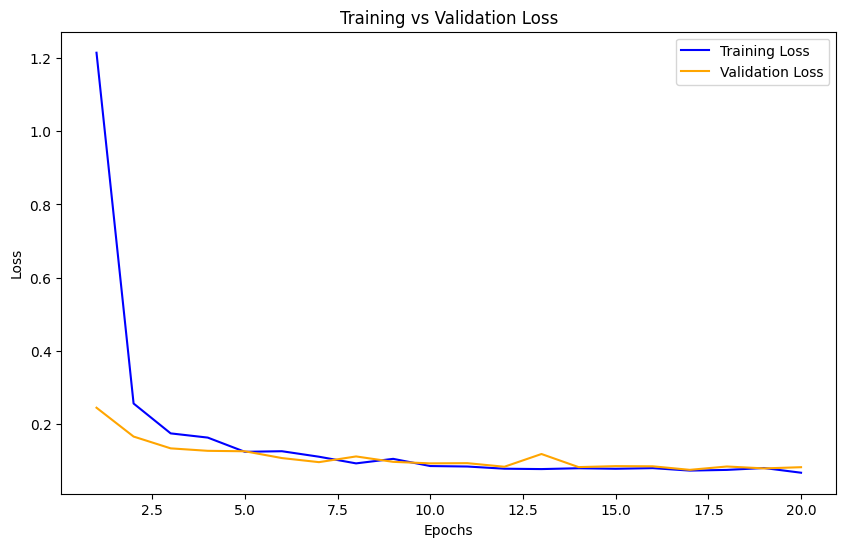

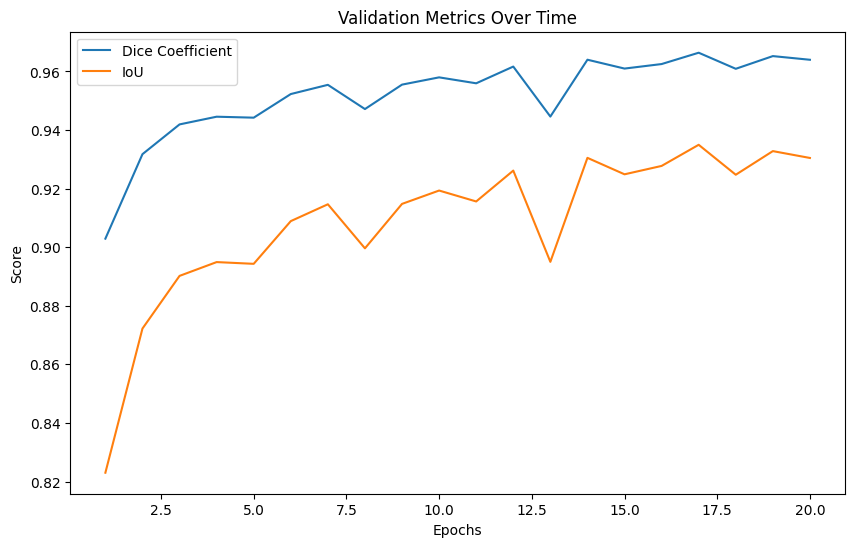

Total Epochs: 3
Only 3 epochs recorded, plotting all.


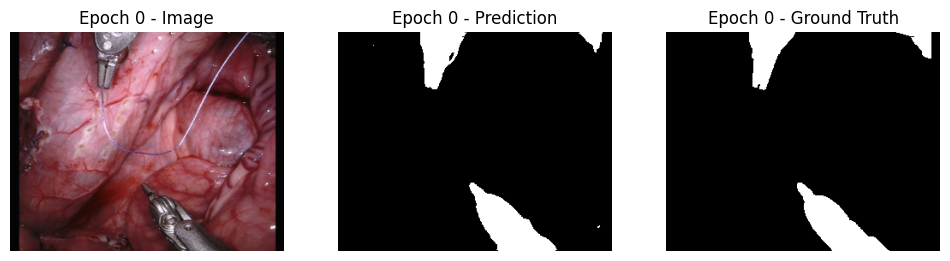

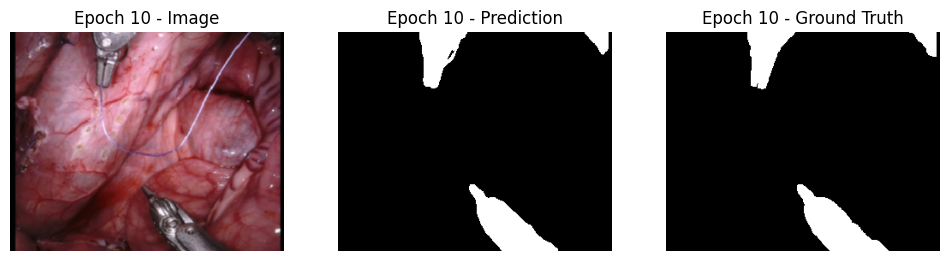

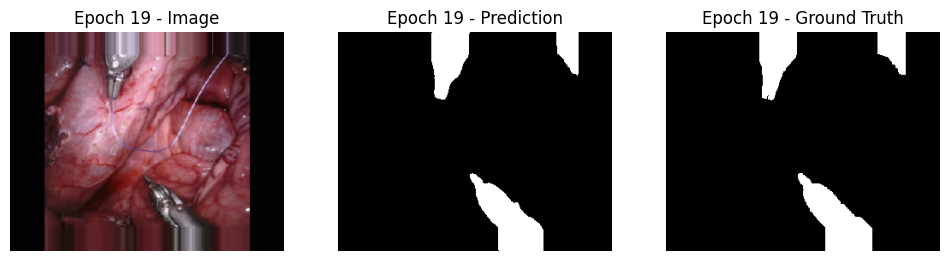

Model saved in the 'SwinUNETRmodels' directory!


In [23]:
if __name__ == "__main__":

    logger = TensorBoardLogger("tb_logs", name="swinunetr_binary_seg")

    early_stop_callback = EarlyStopping(
        monitor="Train_Dice_CE_loss",          # metric name from self.log
        mode="min",                  # because lower loss is better
        patience=5,                  # epochs to wait before stopping
        verbose=True
    )

    checkpoint_callback = ModelCheckpoint(
        monitor="Train_Dice_CE_loss",
        mode="min",
        save_top_k=1,
        dirpath="checkpoints/",
        filename="best-binary-seg-SwinUNETR",
    )

    trainer = Trainer(
        precision="16-mixed",
        accelerator="gpu",
        max_epochs=20,
        #limit_train_batches=0.1,  # or 0.1 to use 10%
        logger=logger,
        callbacks=[early_stop_callback, checkpoint_callback],
    )

    start_train = time.time()
    trainer.fit(
        model=binary_SwinUNETR_model,
        datamodule=binary_endo_data
    )
    end_train = time.time()
    print(f"Training time: {(end_train - start_train)/60:.2f} minutes")

    # Plot the overlaid training and val loss curves per epoch
    binary_SwinUNETR_model.plot_losses()

    # Plot the IOU and DSC curves per epoch
    binary_SwinUNETR_model.plot_metrics()

    # Plot images from last epoch
    binary_SwinUNETR_model.plot_result_by_epoch()

    os.makedirs('SwinUNETRmodels', exist_ok=True)
    # Define file names with paths
    binary_SwinUNETR_model_filename = 'SwinUNETRmodels/binary_SwinUNETR_model.pth'
    # Save the model parameters
    torch.save(binary_SwinUNETR_model.state_dict(), binary_SwinUNETR_model_filename)
    print("Model saved in the 'SwinUNETRmodels' directory!")

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params | Mode  | In sizes         | Out sizes       
------------------------------------------------------------------------------------------
0 | model        | SwinUNETR  | 25.1 M | train | [1, 3, 256, 320] | [1, 5, 256, 320]
1 | DICE_CE_Loss | DiceCELoss | 0      | train | ?                | ?               
------------------------------------------------------------------------------------------
25.1 M    Trainable params
0         Non-trainable params
25.1 M    Total params
100.558   Total estimated model params size (MB)
274       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Logged image from epoch 0


Metric Train_Dice_CE_loss improved. New best score: 1.113


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.281 >= min_delta = 0.0. New best score: 0.832


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.090 >= min_delta = 0.0. New best score: 0.742


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.700


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.658


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.050 >= min_delta = 0.0. New best score: 0.608


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.586


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.575


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.565


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.551


Validation: |          | 0/? [00:00<?, ?it/s]

Logged image from epoch 10


Metric Train_Dice_CE_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.531


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.523


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.518


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.513


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.507


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.494


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.491


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.488


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.487


Validation: |          | 0/? [00:00<?, ?it/s]

Logged image from epoch 19


Metric Train_Dice_CE_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.481
`Trainer.fit` stopped: `max_epochs=20` reached.


Training time: 47.25 minutes


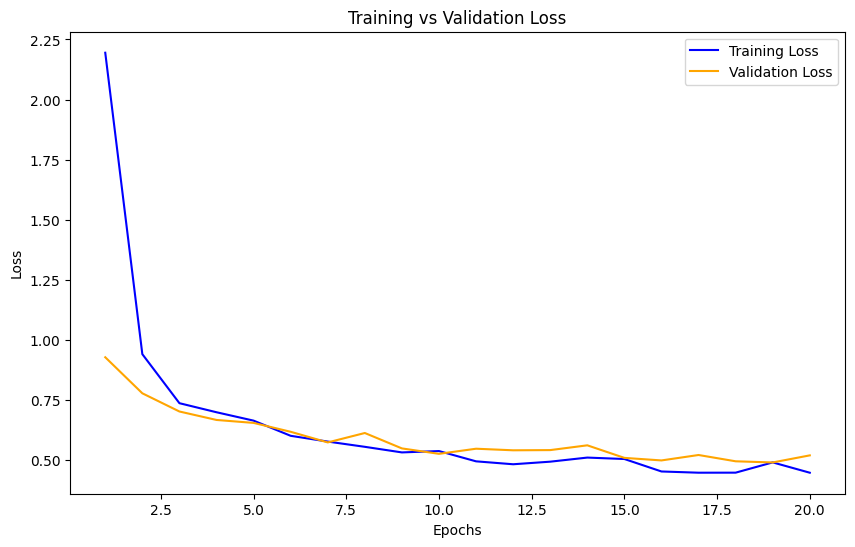

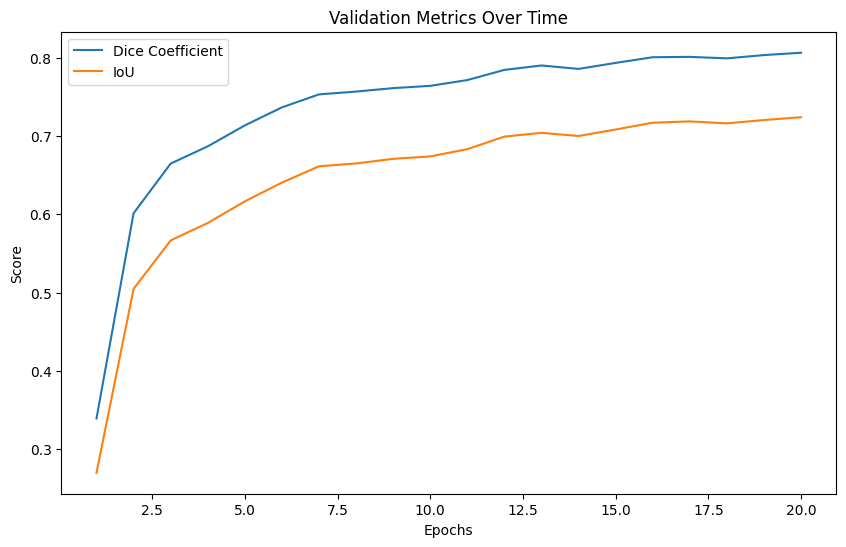

Total Epochs: 3
Only 3 epochs recorded, plotting all.


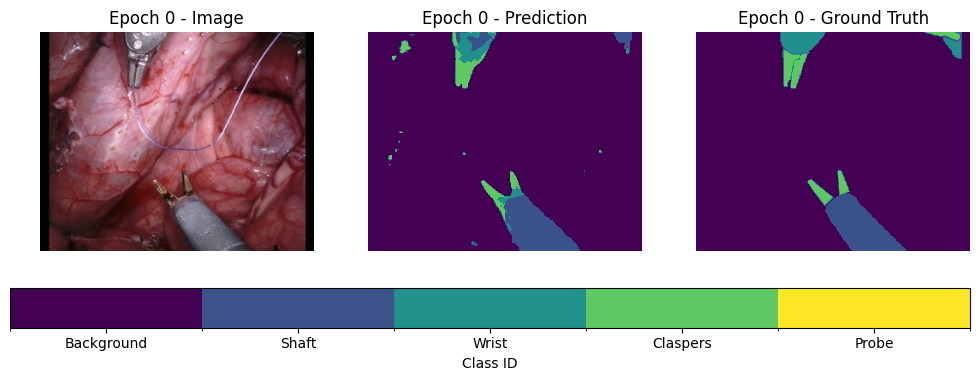

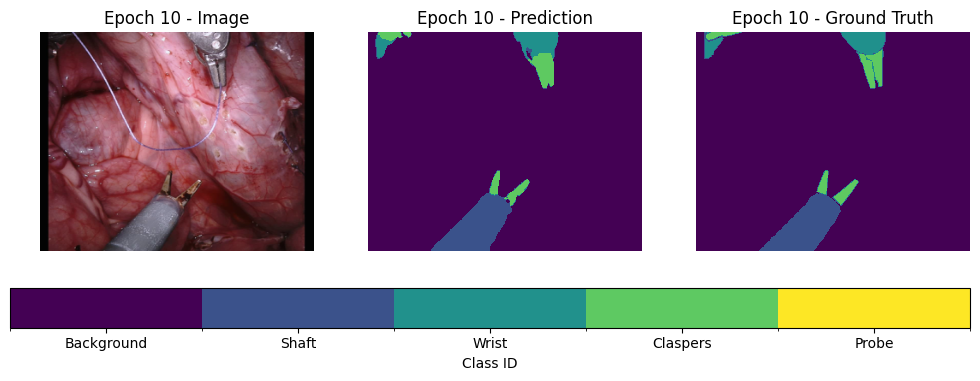

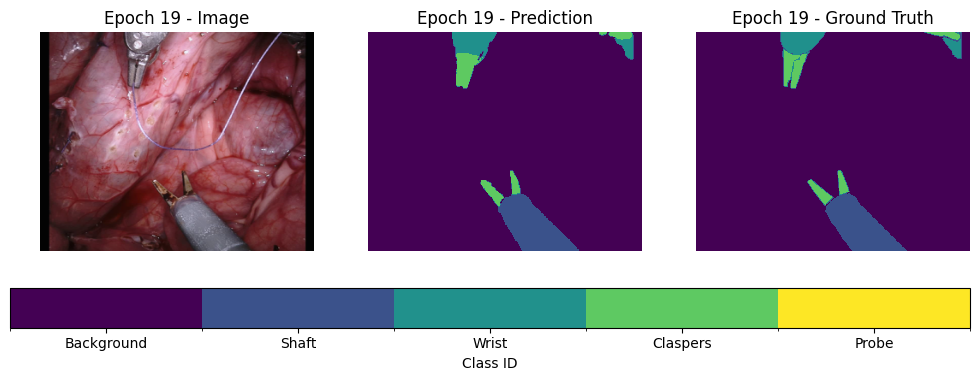

Model saved in the 'SwinUNETRmodels' directory!


In [24]:
if __name__ == "__main__":

    logger = TensorBoardLogger("tb_logs", name="swinunetr_part_seg")

    early_stop_callback = EarlyStopping(
        monitor="Train_Dice_CE_loss",          # metric name from self.log
        mode="min",                  # because lower loss is better
        patience=5,                  # epochs to wait before stopping
        verbose=True
    )

    checkpoint_callback = ModelCheckpoint(
        monitor="Train_Dice_CE_loss",
        mode="min",
        save_top_k=1,
        dirpath="checkpoints/",
        filename="best-part-seg-SwinUNETR",
    )

    trainer = Trainer(
        precision="16-mixed",
        accelerator="gpu",
        max_epochs=20,
        #limit_train_batches=0.1,  # or 0.1 to use 10%
        logger=logger,
        callbacks=[early_stop_callback, checkpoint_callback],
    )

    start_train = time.time()
    trainer.fit(
        model=part_seg_SwinUNETR_model,
        datamodule=part_seg_endo_data
    )
    end_train = time.time()
    print(f"Training time: {(end_train - start_train)/60:.2f} minutes")

    # Plot the overlaid training and val loss curves per epoch
    part_seg_SwinUNETR_model.plot_losses()

    # Plot the IOU and DSC curves per epoch
    part_seg_SwinUNETR_model.plot_metrics()

    # Plot images from last epoch
    part_seg_SwinUNETR_model.plot_result_by_epoch()

    os.makedirs('SwinUNETRmodels', exist_ok=True)
    # Define file names with paths
    part_seg_SwinUNETR_model_filename = 'SwinUNETRmodels/part_seg_SwinUNETR_model.pth'
    # Save the model parameters
    torch.save(part_seg_SwinUNETR_model.state_dict(), part_seg_SwinUNETR_model_filename)
    print("Model saved in the 'SwinUNETRmodels' directory!")

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Checkpoint directory C:\Users\dsumm\OneDrive\Documents\UMD ENPM Robotics Files\BIOE658B (Intro to Medical Image Analysis)\Project\code\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params | Mode  | In sizes         | Out sizes       
------------------------------------------------------------------------------------------
0 | model        | SwinUNETR  | 25.1 M | train | [1, 3, 256, 320] | [1, 8, 256, 320]
1 | DICE_CE_Loss | DiceCELoss | 0      | train | ?                | ?               
------------------------------------------------------------------------------------------
25.1 M    Trainable params
0         Non-trainable params
25.1 M    Total params
100.558   Total estimated model params size (MB)
274       Modules in train mode
0         Modules in eval 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Logged image from epoch 0


Metric Train_Dice_CE_loss improved. New best score: 1.311


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.186 >= min_delta = 0.0. New best score: 1.125


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.093 >= min_delta = 0.0. New best score: 1.033


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.064 >= min_delta = 0.0. New best score: 0.969


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.044 >= min_delta = 0.0. New best score: 0.925


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.044 >= min_delta = 0.0. New best score: 0.881


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.870


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.859


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.854


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.849


Validation: |          | 0/? [00:00<?, ?it/s]

Logged image from epoch 10


Metric Train_Dice_CE_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.826


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.822


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.815


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.811


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.805


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.797


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.795


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.793


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.790


Validation: |          | 0/? [00:00<?, ?it/s]

Logged image from epoch 19


Metric Train_Dice_CE_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.789
`Trainer.fit` stopped: `max_epochs=20` reached.


Training time: 45.86 minutes


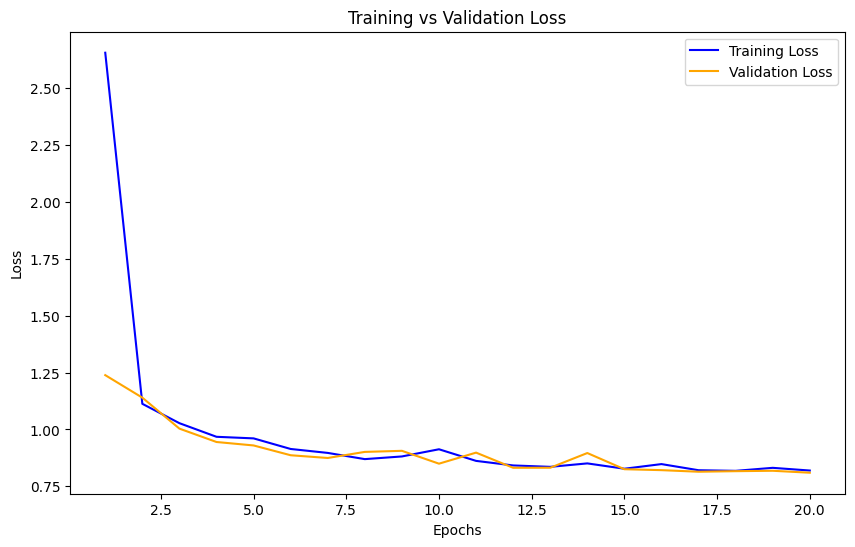

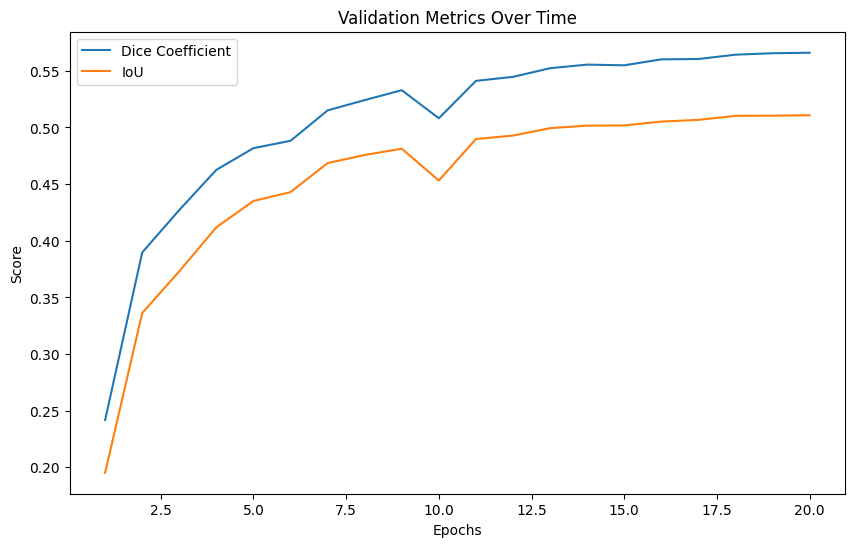

Total Epochs: 3
Only 3 epochs recorded, plotting all.


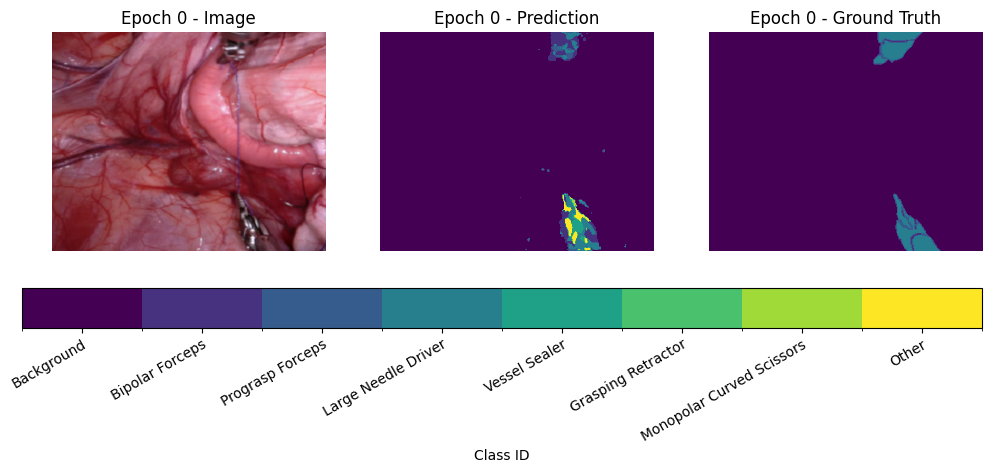

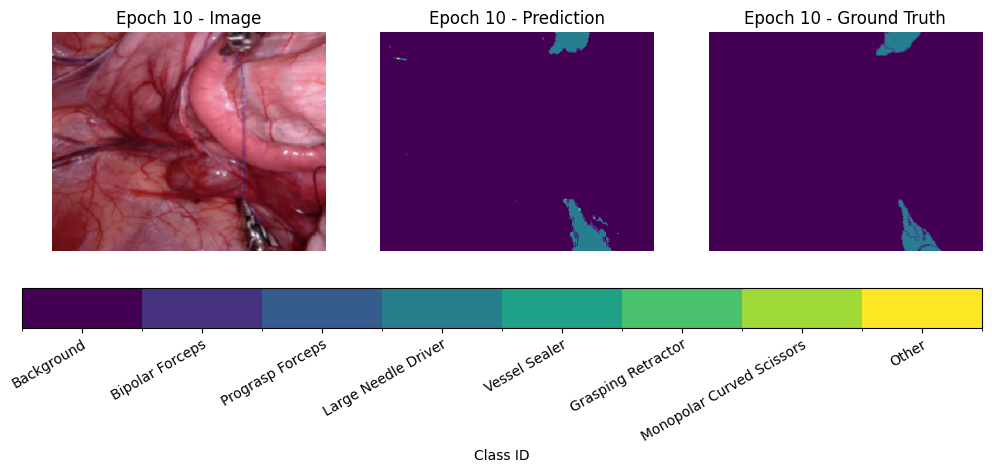

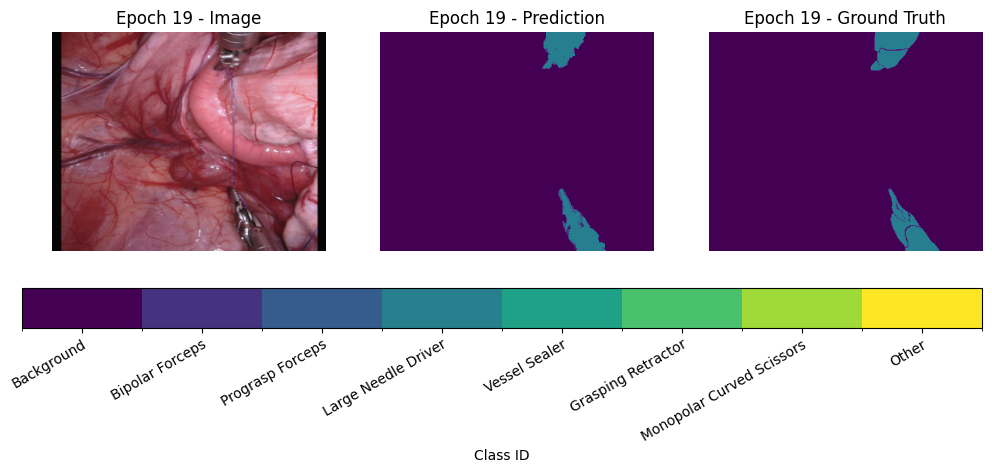

Model saved in the 'SwinUNETRmodels' directory!


In [25]:
if __name__ == "__main__":

    logger = TensorBoardLogger("tb_logs", name="swinunetr_instrument_seg")

    early_stop_callback = EarlyStopping(
        monitor="Train_Dice_CE_loss",          # metric name from self.log
        mode="min",                  # because lower loss is better
        patience=5,                  # epochs to wait before stopping
        verbose=True
    )

    checkpoint_callback = ModelCheckpoint(
        monitor="Train_Dice_CE_loss",
        mode="min",
        save_top_k=1,
        dirpath="checkpoints/",
        filename="best-instr-seg-SwinUNETR",
    )

    trainer = Trainer(
        precision="16-mixed",
        accelerator="gpu",
        max_epochs=20,
        #limit_train_batches=0.1,  # or 0.1 to use 10%
        logger=logger,
        callbacks=[early_stop_callback, checkpoint_callback],
    )

    start_train = time.time()
    trainer.fit(
        model=instr_seg_SwinUNETR_model,
        datamodule=instr_seg_endo_data
    )
    end_train = time.time()
    print(f"Training time: {(end_train - start_train)/60:.2f} minutes")

    # Plot the overlaid training and val loss curves per epoch
    instr_seg_SwinUNETR_model.plot_losses()

    # Plot the IOU and DSC curves per epoch
    instr_seg_SwinUNETR_model.plot_metrics()

    # Plot images from last epoch
    instr_seg_SwinUNETR_model.plot_result_by_epoch()

    os.makedirs('SwinUNETRmodels', exist_ok=True)
    instr_seg_SwinUNETR_model_filename = 'SwinUNETRmodels/instr_seg_SwinUNETR_model.pth'
    torch.save(instr_seg_SwinUNETR_model.state_dict(), instr_seg_SwinUNETR_model_filename)
    print("Model saved in the 'SwinUNETRmodels' directory!")

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Checkpoint directory C:\Users\dsumm\OneDrive\Documents\UMD ENPM Robotics Files\BIOE658B (Intro to Medical Image Analysis)\Project\code\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params | Mode  | In sizes         | Out sizes        
-------------------------------------------------------------------------------------------
0 | model        | SwinUNETR  | 25.1 M | train | [1, 3, 256, 320] | [1, 21, 256, 320]
1 | DICE_CE_Loss | DiceCELoss | 0      | train | ?                | ?                
-------------------------------------------------------------------------------------------
25.1 M    Trainable params
0         Non-trainable params
25.1 M    Total params
100.561   Total estimated model params size (MB)
274       Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Logged image from epoch 0


Metric Train_Dice_CE_loss improved. New best score: 1.593


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.279 >= min_delta = 0.0. New best score: 1.314


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.086 >= min_delta = 0.0. New best score: 1.229


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.074 >= min_delta = 0.0. New best score: 1.155


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.051 >= min_delta = 0.0. New best score: 1.103


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.049 >= min_delta = 0.0. New best score: 1.055


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.033


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.020


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.006


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Logged image from epoch 10


Metric Train_Dice_CE_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.979


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.971


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.967


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.961


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.957


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.950


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.947


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.944


Validation: |          | 0/? [00:00<?, ?it/s]

Metric Train_Dice_CE_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.942


Validation: |          | 0/? [00:00<?, ?it/s]

Logged image from epoch 19


Metric Train_Dice_CE_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.939
`Trainer.fit` stopped: `max_epochs=20` reached.


Training time: 45.99 minutes


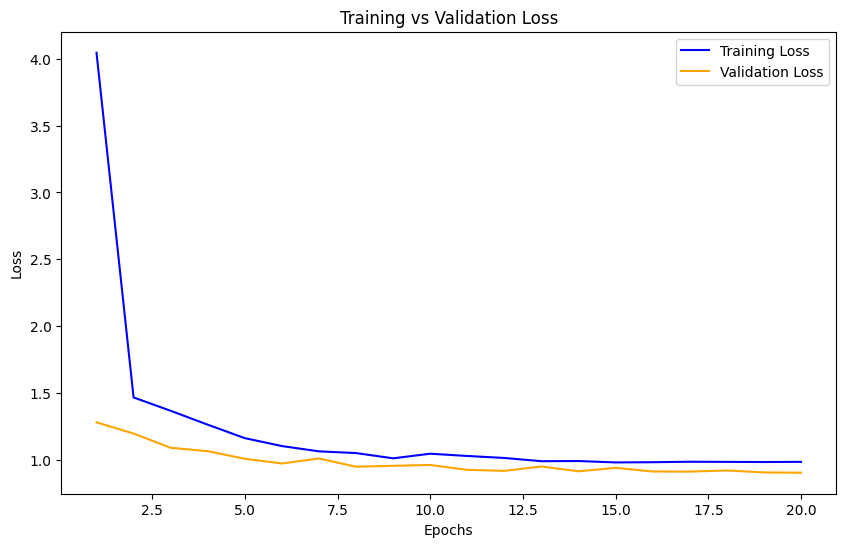

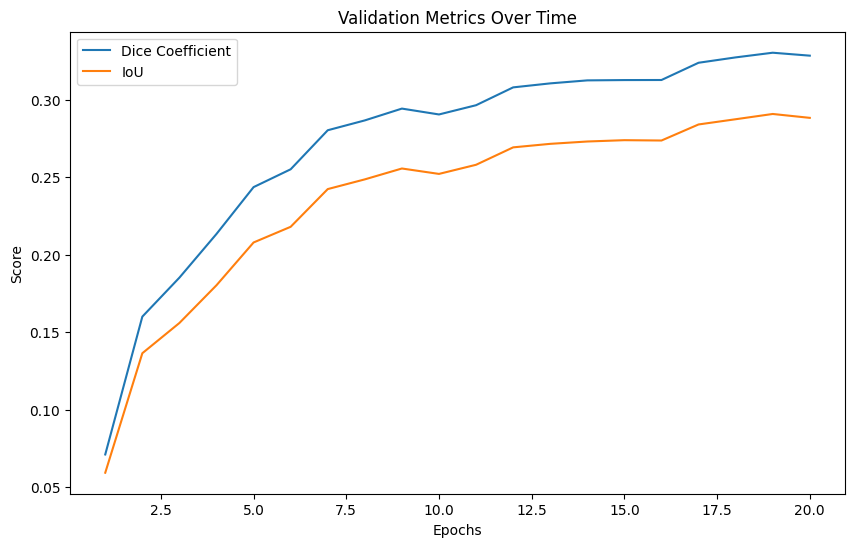

Total Epochs: 3
Only 3 epochs recorded, plotting all.


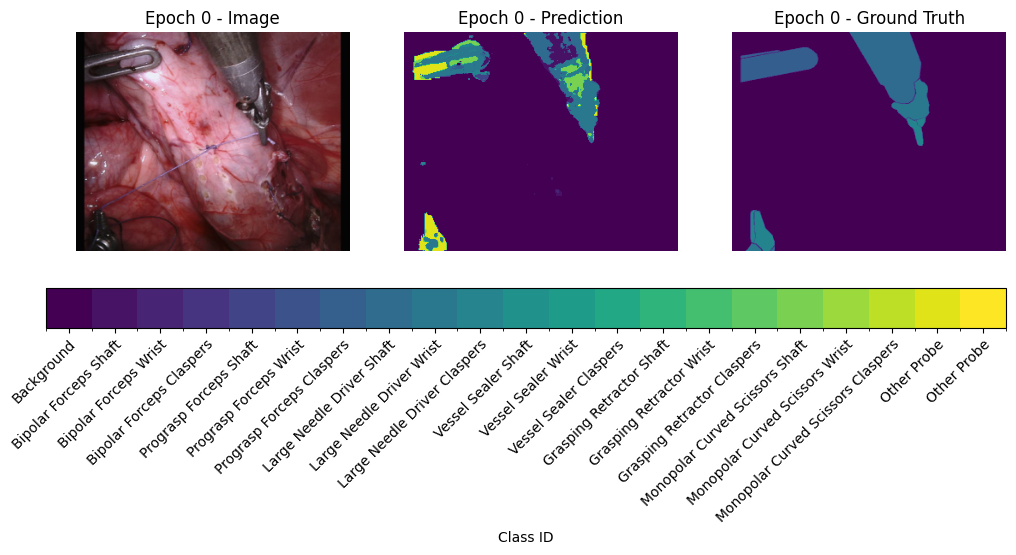

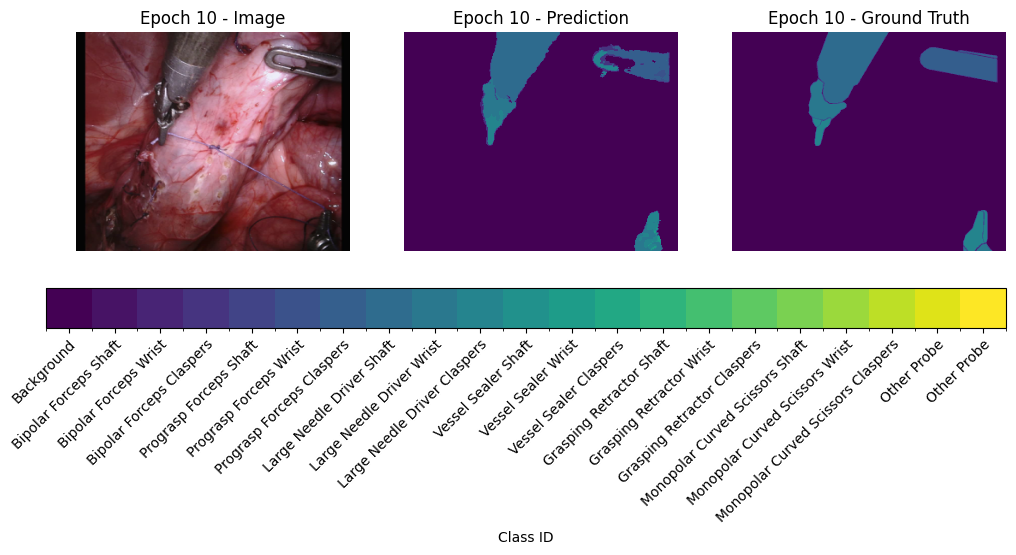

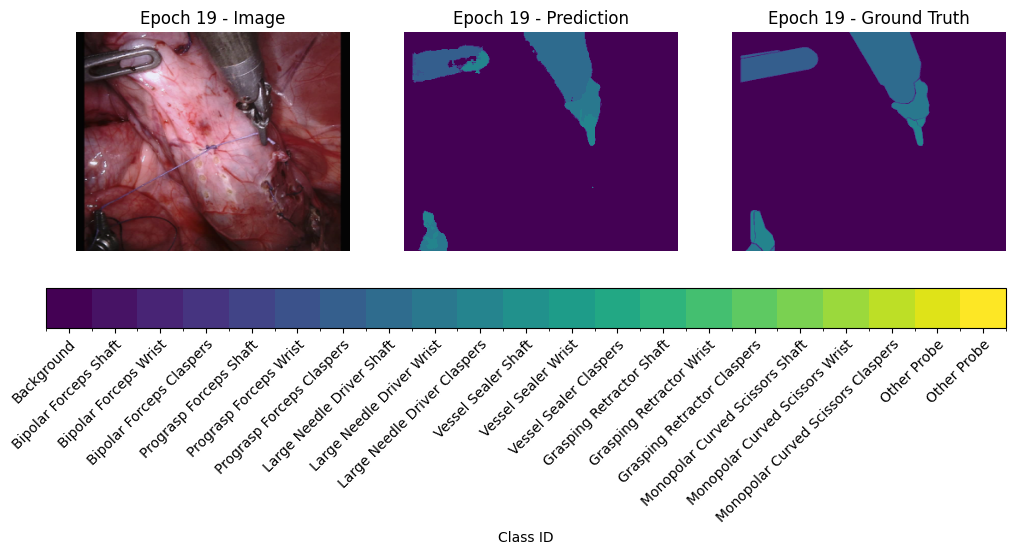

Model saved in the 'SwinUNETRmodels' directory!


In [26]:
if __name__ == "__main__":

    logger = TensorBoardLogger("tb_logs", name="swinunetr_part_instrument_seg")

    early_stop_callback = EarlyStopping(
        monitor="Train_Dice_CE_loss",          # metric name from self.log
        mode="min",                  # because lower loss is better
        patience=5,                  # epochs to wait before stopping
        verbose=True
    )

    checkpoint_callback = ModelCheckpoint(
        monitor="Train_Dice_CE_loss",
        mode="min",
        save_top_k=1,
        dirpath="checkpoints/",
        filename="best-part-instr-seg-SwinUNETR",
    )

    trainer = Trainer(
        precision="16-mixed",
        accelerator="gpu",
        max_epochs=20,
        #limit_train_batches=0.1,  # or 0.1 to use 10%
        logger=logger,
        callbacks=[early_stop_callback, checkpoint_callback],
    )

    start_train = time.time()
    trainer.fit(
        model=part_instr_seg_SwinUNETR_model,
        datamodule=part_instr_seg_endo_data
    )
    end_train = time.time()
    print(f"Training time: {(end_train - start_train)/60:.2f} minutes")

    # Plot the overlaid training and val loss curves per epoch
    part_instr_seg_SwinUNETR_model.plot_losses()

    # Plot the IOU and DSC curves per epoch
    part_instr_seg_SwinUNETR_model.plot_metrics()

    # Plot images from last epoch
    part_instr_seg_SwinUNETR_model.plot_result_by_epoch()

    os.makedirs('SwinUNETRmodels', exist_ok=True)
    part_instr_seg_SwinUNETR_model_filename = 'SwinUNETRmodels/part_instr_seg_SwinUNETR_model.pth'
    torch.save(part_instr_seg_SwinUNETR_model.state_dict(), part_instr_seg_SwinUNETR_model_filename)
    print("Model saved in the 'SwinUNETRmodels' directory!")